# Homework 3 - Uncovering World Events using Twitter Hashtags

## ... and learning about Spark `DataFrames` along the way

In this notebook, we will use temporal information about Twitter hashtags to discover trending topics and potentially uncover world events as they occurred. 

__Hand-in:__

- __Due: 28.04.2020 23:59:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

### Hashtags

The idea here is that when an event is happening and people are having a conversation about it on Twitter, a set of uniform hashtags that represent the event spontaneously evolves. Twitter users then use those hashtags to communicate with one another. Some hashtags, like `#RT` for "retweet" or just `#retweet` are used frequently and don't tell us much about what is going on. But a sudden appearance of a hashtag like `#oscars` probably indicates that the oscars are underway. For a particularly cool example of this type of analysis, check out [this blog post about earthquake detection using Twitter data](https://blog.twitter.com/official/en_us/a/2015/usgs-twitter-data-earthquake-detection.html) (although they search the text and not necessarily hashtags).

In [1]:
%%local
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

## Initialize the `SparkSession`

In [2]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3772,application_1587988164357_0388,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3744,application_1587988164357_0360,pyspark,idle,Link,Link,
3750,application_1587988164357_0366,pyspark,busy,Link,Link,
3751,application_1587988164357_0367,pyspark,busy,Link,Link,
3752,application_1587988164357_0368,pyspark,idle,Link,Link,
3754,application_1587988164357_0370,pyspark,idle,Link,Link,
3755,application_1587988164357_0371,pyspark,idle,Link,Link,
3756,application_1587988164357_0372,pyspark,busy,Link,Link,
3757,application_1587988164357_0373,pyspark,idle,Link,Link,✔


In [4]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.
send_to_spark,%%send_to_spark -o variable -t str -n var,"Sends a variable from local output to spark cluster. Parameters: -i VAR_NAME: Local Pandas DataFrame(or String) of name VAR_NAME will be available in the %%spark context as a Spark dataframe(or String) with the same name. -t TYPE: Specifies the type of variable passed as -i. Available options are: `str` for string and `df` for Pandas DataFrame. Optional, defaults to `str`. -n NAME: Custom name of variable passed as -i. Optional, defaults to -i variable name. -m MAXROWS: Maximum amount of Pandas rows that will be sent to Spark. Defaults to 2500."


## PART I: Set up the hashtag `DataFrame` (10 points / 60)

We have prepared the hashtag data spanning the time from May to July, 2016. This is a significant time in modern European history, e.g. see [Brexit](https://en.wikipedia.org/wiki/Brexit). Lets see if we can see any interesting trends about these events in the Twitter data. 

In [3]:
import pyspark.sql.functions as functions

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### I.a: TODO (1 point/10)

Load the **parquet** data from `/data/twitter/parquet/hashtags` into a Spark dataframe using the appropriate `SparkSession` method. 

Look at the first few rows of the dataset - note the timestamp and its units!

In [4]:
df = spark.read.parquet("/data/twitter/parquet/hashtags")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp_s: long (nullable = true)
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- hashtag: string (nullable = true)

In [8]:
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+----+-------+
|timestamp_s|                id|lang|hashtag|
+-----------+------------------+----+-------+
| 1464768480|737918607980670976|  tr|lovebts|
| 1464768480|737918607980670976|  tr|  방탄소년단|
| 1464768480|737918607963873281|  ja|tokyofm|
| 1464768480|737918607976452096|  en|SotoBot|
| 1464768480|737918607976497152|  en| Fenton|
+-----------+------------------+----+-------+
only showing top 5 rows

### User-defined functions

A neat trick of spark dataframes is that you can essentially use something very much like an RDD `map` method but without switching to the RDD. If you are familiar with database languages, this works very much like e.g. a user-defined function in SQL. 

So, for example, if we wanted to make a user-defined python function that returns the hashtags in lowercase, we could do something like this:

In [5]:
@functions.udf
def lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The @functions.udf is a "decorator" -- this is really handy python syntactic sugar and in this case is equivalent to:

```python
def lowercase(text):
    return text.lower()
    
lowercase = functions.udf(lowercase)
```

It basically takes our function and adds to its functionality. In this case, it registers our function as a pyspark dataframe user-defined function (UDF).

Using these UDFs is very straightforward and analogous to other Spark dataframe operations. For example:

In [6]:
df.select(lowercase(df.hashtag)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|lowercase(hashtag)|
+------------------+
|           lovebts|
|             방탄소년단|
|           tokyofm|
|           sotobot|
|            fenton|
|      vintageglass|
|         glassbell|
|           vintage|
|             1970s|
|               mod|
|         ابن_الغيم|
| creativitybooster|
|     growthhacking|
|  entrepreneurship|
|     jewelryonetsy|
|           jetteam|
|        teenchoice|
|  choicemalehottie|
|        nowplaying|
|              maui|
+------------------+
only showing top 20 rows

Using a framework like Spark is all about understanding the ins and outs of how it functions and knowing what it offers. One of the cool things about the dataframe API is that many functions are already defined for you (turning strings into lowercase being one of them). 

### I.b: TODO (2 points / 10)

Find the [Spark python API documentation](https://spark.apache.org/docs/latest/api/python/index.html). Look for the `sql` section and find the listing of `sql.functions`. Repeat the above (turning hashtags into lowercase) but use the built-in function.

In [7]:
# Create a new dataframe with hashtags in lowercase and remove unnecessary columns
df_lowercase = df.withColumn('hashtag_lower', functions.lower(functions.col('hashtag'))) 
df_lowercase = df_lowercase.drop(df_lowercase.id).drop(df_lowercase.hashtag)
df_lowercase = df_lowercase.withColumnRenamed('hashtag_lower', 'hashtag')
df_lowercase.select('hashtag').show() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|          hashtag|
+-----------------+
|          lovebts|
|            방탄소년단|
|          tokyofm|
|          sotobot|
|           fenton|
|     vintageglass|
|        glassbell|
|          vintage|
|            1970s|
|              mod|
|        ابن_الغيم|
|creativitybooster|
|    growthhacking|
| entrepreneurship|
|    jewelryonetsy|
|          jetteam|
|       teenchoice|
| choicemalehottie|
|       nowplaying|
|             maui|
+-----------------+
only showing top 20 rows

We'll work with a combination of these built-in functions and user-defined functions for the remainder of this homework. 

### I.c: TODO (3 points/10)

Create `english_df` consisting of **lowercase** hashtags from only english-language tweets. In addition, convert the timestamp to a more readable format like this and name the column `date`:

```
2016-05-01 08:30:00
```

Your `english_df` should look something like this:

```
+-----------+----+------------+-------------------+
|timestamp_s|lang|     hashtag|               date|
+-----------+----+------------+-------------------+
| 1464768480|  en|     sotobot|2016-06-01 10:08:00|
| 1464768480|  en|      fenton|2016-06-01 10:08:00|
| 1464768480|  en|vintageglass|2016-06-01 10:08:00|
| 1464768480|  en|   glassbell|2016-06-01 10:08:00|
| 1464768480|  en|     vintage|2016-06-01 10:08:00|
+-----------+----+------------+-------------------+
```

In [8]:
# Filter out all languages but english and convert timestamp to correct format in new column
english_df = df_lowercase.filter(df_lowercase.lang == 'en')
english_df = english_df.withColumn('date', functions.from_unixtime('timestamp_s','yyyy-MM-dd hh:mm:ss')) 
english_df.show(30)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----+------------------+-------------------+
|timestamp_s|lang|           hashtag|               date|
+-----------+----+------------------+-------------------+
| 1464768480|  en|           sotobot|2016-06-01 10:08:00|
| 1464768480|  en|            fenton|2016-06-01 10:08:00|
| 1464768480|  en|      vintageglass|2016-06-01 10:08:00|
| 1464768480|  en|         glassbell|2016-06-01 10:08:00|
| 1464768480|  en|           vintage|2016-06-01 10:08:00|
| 1464768480|  en|             1970s|2016-06-01 10:08:00|
| 1464768480|  en|               mod|2016-06-01 10:08:00|
| 1464768481|  en| creativitybooster|2016-06-01 10:08:01|
| 1464768481|  en|     growthhacking|2016-06-01 10:08:01|
| 1464768481|  en|  entrepreneurship|2016-06-01 10:08:01|
| 1464768481|  en|     jewelryonetsy|2016-06-01 10:08:01|
| 1464768481|  en|           jetteam|2016-06-01 10:08:01|
| 1464768481|  en|        teenchoice|2016-06-01 10:08:01|
| 1464768481|  en|  choicemalehottie|2016-06-01 10:08:01|
| 1464768481| 

### I.d: TODO (4 points/10)

We "claim" the data contains all twitters from May to July 2017, however, that's not true. Check which (date, hour) are in `english_df` and which are missing, e.g. 2016-05-01, 10h is in the dataframe while 2016-04-01, 10h not.

In [8]:
import pyspark.sql.functions
import pandas as pd
from pyspark.sql.functions import monotonically_increasing_id

# Create a date range with all dates and hours from 1st of May to 1st of July
date_clean = pd.date_range(start='5/1/2016 1:00', end='8/1/2016 07:00', freq='H')

# Extract all of the dates and hours from english_df and keep only distinct ones
date_dirty = english_df.withColumn('date_hour', functions.date_trunc('hour', english_df.date))
date_dirty = date_dirty.select('date_hour').distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

***Observations:*** *When creating the date range, we get a range of hours between 00-24. However, in our english_df, we only have hours in the range 01-12. This is most likely due to the fact that the timestamps were stored on Twitter using and AM & PM format. To be able to find which dates and hours that are missing in our date range, we remove the hours 00 & 13-23 from the date range.*

In [9]:
from pyspark.sql.functions import hour
import datetime

# Show what hours that are stored in the twitter df
english_df.select(hour('date').alias('hour')).distinct().sort('hour').show()

# Keep only the relevant hours in date range
date_clean = date_clean[date_clean.hour < 13]
date_clean = date_clean[date_clean.hour > 0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+
|hour|
+----+
|   1|
|   2|
|   3|
|   4|
|   5|
|   6|
|   7|
|   8|
|   9|
|  10|
|  11|
|  12|
+----+

In [10]:
# Create Spark dataframe with date_clean in order to be able to use subtract()
date_clean = pd.DataFrame(date_clean).rename(columns={0:'date_hour'})
date_clean = sqlContext.createDataFrame(date_clean)

# Get the dates & hours missing in english_df
missing = date_clean.subtract(date_dirty).sort('date_hour')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
missing.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

74

In [12]:
missing.show(74)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|          date_hour|
+-------------------+
|2016-05-02 01:00:00|
|2016-05-02 02:00:00|
|2016-06-02 08:00:00|
|2016-06-02 09:00:00|
|2016-06-02 10:00:00|
|2016-06-02 11:00:00|
|2016-06-03 01:00:00|
|2016-06-03 02:00:00|
|2016-06-03 03:00:00|
|2016-06-03 04:00:00|
|2016-06-03 05:00:00|
|2016-06-03 06:00:00|
|2016-06-03 07:00:00|
|2016-06-03 08:00:00|
|2016-06-03 09:00:00|
|2016-06-03 10:00:00|
|2016-06-03 11:00:00|
|2016-06-03 12:00:00|
|2016-06-04 01:00:00|
|2016-06-04 02:00:00|
|2016-06-04 03:00:00|
|2016-06-04 04:00:00|
|2016-06-04 05:00:00|
|2016-06-04 06:00:00|
|2016-06-04 07:00:00|
|2016-06-04 08:00:00|
|2016-06-04 09:00:00|
|2016-06-04 10:00:00|
|2016-06-04 11:00:00|
|2016-06-04 12:00:00|
|2016-06-05 01:00:00|
|2016-06-05 02:00:00|
|2016-06-05 03:00:00|
|2016-06-05 04:00:00|
|2016-06-05 05:00:00|
|2016-06-05 06:00:00|
|2016-06-05 07:00:00|
|2016-06-05 08:00:00|
|2016-06-05 09:00:00|
|2016-06-05 10:00:00|
|2016-06-05 11:00:00|
|2016-06-05 12:00:00|
|2016-06-0

***Observations:*** *We can see that there are 74 dates & hours missing in our english_df in the time period 1st of May to 1st of July 2016. Some dates have no data at all, for example the 3rd of June 2016.
More specifically, the following timestamps are missing:*
- 2016-05-02 01-02h
- 2016-06-02 08-11h
- 2016-06-03 01-12h
- 2016-06-04 01-12h
- 2016-06-05 01-12h
- 2016-06-06 01-12h
- 2016-06-07 01-12h
- 2016-06-17 01-12h

## PART II: Twitter hashtag trends (50 points / 60)

In this section we will try to do a slightly more complicated analysis of the tweets. Our goal is to get an idea of tweet frequency as a function of time for certain hashtags. 

Lets build this up in steps. First, lets see how we can start to organize the tweets by their timestamps. 

As a first easy example, lets say we just want to count the number of tweets per minute over the entire span of our data. For this, we first need a "global" minute value, e.g. "minute of the year" or something similar. 

Spark provides us with some handy built-in dataframe functions that are made for transforming date and time fields. 

Have a look [here](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) to see the whole list of custom dataframe functions - you will need to use them to complete the next set of TODO items.

Note that the functions can be combined. Consider the following dataframe and its transformation:

In [13]:
from pyspark.sql import Row

# Create a sample dataframe with one column "degrees" going from 0 to 180
test_df = spark.createDataFrame(spark.sparkContext.range(180).map(lambda x: Row(degrees=x)), ['degrees'])

# Define a function "sin_rad" that first converts degrees to radians and then takes the sine using built-in functions
sin_rad = functions.sin(functions.radians(test_df.degrees))

test_df.select(sin_rad).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|SIN(RADIANS(degrees))|
+---------------------+
|                  0.0|
|  0.01745240643728351|
|  0.03489949670250097|
|  0.05233595624294383|
|   0.0697564737441253|
|  0.08715574274765817|
|  0.10452846326765346|
|  0.12186934340514748|
|  0.13917310096006544|
|  0.15643446504023087|
|  0.17364817766693033|
|   0.1908089953765448|
|  0.20791169081775931|
|  0.22495105434386498|
|  0.24192189559966773|
|  0.25881904510252074|
|  0.27563735581699916|
|   0.2923717047227367|
|   0.3090169943749474|
|   0.3255681544571567|
+---------------------+
only showing top 20 rows

### DataFrames `groupBy`

We used `groupBy` already in the previous notebook, but here we will take more advantage of its features. 

One important thing to note is that unlike other RDD or DataFrame transformations, the `groupBy` does not return another DataFrame, but a `GroupedData` object instead, with its own methods. These methods allow you to do various transformations and aggregations on the data of the grouped rows. 

Conceptually the procedure is a lot like this:

![groupby](https://i.stack.imgur.com/sgCn1.jpg)

The column that is used for the `groupBy` is the `key` - once we have the values of a particular key all together, we can use various aggregation functions on them to generate a transformed dataset. In this example, the aggregation function is a simple `sum`. In the simple procedure below, the `key` will be the hashtag.

### II.a: TODO (1 point / 50)

Calculate the top five most common hashtags in the whole english-language dataset.

This should be your result:

```
+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800527|
|veranomtv2016|539028|
|   teenchoice|345208|
|   nowplaying|178561|
|  gameinsight|165237|
+-------------+------+
```

In [14]:
# Show the top 5 most common hashtags
hashtag_count = english_df.groupBy('hashtag')\
                          .agg(functions.count('hashtag').alias('count'))\
                          .sort(functions.desc(('count')))
hashtag_count.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800527|
|veranomtv2016|539028|
|   teenchoice|345208|
|   nowplaying|178561|
|  gameinsight|165237|
+-------------+------+
only showing top 5 rows

## Daily hashtag trends

Now we will start to complicate the analysis a bit. Remember, our goal is to uncover trending topics on a timescale of a few days. A much needed column then is simply `day`. To convert the date string into day-of-year, you can use the built-in [dayofyear](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) function. 

In the subsequent sections we will then not only see which hashtags are globally most popular, but which ones experience the biggest changes in popularity - those are the "trending" topics. If there is suddenly a substantial increase of a hashtag over a matter of a day or two, it may signify an event taking place. 

### II.b: TODO (2 points / 50)

Create a dataframe called `daily_hashtag` that includes the columns `month`, `week`, `day` and `hashtag`. Use the `english_df` you made above to start, and make sure you find the appropriate spark dataframe functions to make your life easier. Show the result.

Try to match this view:

```
+-----+----+---+------------+
|month|week|day|     hashtag|
+-----+----+---+------------+
|    6|  22|153|     sotobot|
|    6|  22|153|      fenton|
|    6|  22|153|vintageglass|
|    6|  22|153|   glassbell|
|    6|  22|153|     vintage|
+-----+----+---+------------+
```

In [10]:
# Drop unnecessary columns
daily_hashtag = english_df.drop(english_df.timestamp_s).drop(english_df.lang)

# Create new dataframe with month, week of the year and day of the year
daily_hashtag = daily_hashtag.withColumn('month', functions.month(english_df.date))\
                             .withColumn('week', functions.weekofyear(english_df.date))\
                             .withColumn('day', functions.dayofyear(english_df.date))
daily_hashtag = daily_hashtag.select(functions.col('month'), functions.col('week'), 
                                     functions.col('day'), functions.col('hashtag'))
daily_hashtag.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+---+------------+
|month|week|day|     hashtag|
+-----+----+---+------------+
|    6|  22|153|     sotobot|
|    6|  22|153|      fenton|
|    6|  22|153|vintageglass|
|    6|  22|153|   glassbell|
|    6|  22|153|     vintage|
+-----+----+---+------------+
only showing top 5 rows

### II.c: TODO (2 points / 50)

Now we want to calculate the number of times a hashtag is used per day. Sort in descending order of daily counts and show the result. Call the resulting dataframe `day_counts`.

Your output should look like this:

```
+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|204|mtvhottest|  29|66372|
|205|mtvhottest|  29|63495|
|207|mtvhottest|  30|60768|
|208|mtvhottest|  30|59065|
|199|mtvhottest|  28|57956|
+---+----------+----+-----+
```

<div class="alert alert-info">
<p>Make sure you use `cache()` when you create `day_counts` because we will need it in the steps that follow!</p>
</div>

In [11]:
# Create new dataframe with daily counts of all hashtags
day_counts = daily_hashtag.cache()
day_counts = day_counts.groupBy('day','hashtag','week')\
                       .agg(functions.count('hashtag').alias('count'))\
                       .sort(functions.desc(('count')))
day_counts.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|204|mtvhottest|  29|66372|
|205|mtvhottest|  29|63495|
|207|mtvhottest|  30|60768|
|208|mtvhottest|  30|59065|
|199|mtvhottest|  28|57956|
+---+----------+----+-----+
only showing top 5 rows

### II.d: TODO (2 points / 50)

To get an idea of which hashtags stay popular for several days, calculate the average number of daily occurences for each week. 

__Hint:__ use the `week` column we created above. Sort in descending order and show the top 20.

In [17]:
# Calculate the average number of daily occurences for each week
week_avg = day_counts.cache()
week_avg = week_avg.groupBy('week', 'hashtag')\
                   .agg(functions.avg('count').alias('daily_occur_avg'))\
                   .sort(functions.desc(('daily_occur_avg')))
week_avg.show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-------------------+------------------+
|week|            hashtag|   daily_occur_avg|
+----+-------------------+------------------+
|  29|         mtvhottest| 52061.42857142857|
|  30|         mtvhottest|           47927.0|
|  19|         teenchoice|20068.571428571428|
|  25|      veranomtv2016| 17867.85714285714|
|  26|      veranomtv2016| 17116.14285714286|
|  27|      veranomtv2016| 14476.57142857143|
|  31|         mtvhottest|           14062.0|
|  30|      veranomtv2016|12510.285714285714|
|  28|         mtvhottest|12287.714285714286|
|  23|      mtvawardsstar|12191.833333333334|
|  23|       ripchristina|           11963.5|
|  27|      altonsterling|           10266.2|
|  30|       demsinphilly|10063.714285714286|
|  28|aldub1stanniversary|           8413.25|
|  29|      veranomtv2016| 8323.857142857143|
|  29|           rncincle| 8195.285714285714|
|  30| pushawardslizquens|            8148.0|
|  25|       1dreamboy2ff|            7219.0|
|  25|             brexit| 7021.71

### Using `Window` functions 

Window functions are another awesome feature of dataframes. They allow users to accomplish complex tasks using very concise and simple code. 

Above we computed just the hashtag that had the most occurrences on *any* day. Now lets say we want to know the top tweets for *each* day.  

This is a non-trivial thing to compute and requires "windowing" our data. I recommend reading this [window functions article](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) to get acquainted with the idea. You can think of a window function as a fine-grained and more flexible `groupBy`. 

There are two things we need to define to use window functions:

1. the "window" to use, based on which columns (partitioning) and how the rows should be ordered 
2. the computation to carry out for each windowed group, e.g. a max, an average etc.

Lets see how this works by example. We will define a window function, `daily_window` that will partition data based on the `day` column. Within each window, the rows will be ordered by the daily hashtag count that we computed above. Finally, we will use the rank function **over** this window to give us the ranking of top tweets. 

In the end, this is a fairly complicated operation achieved in just a few lines of code! (can you think of how to do this with an RDD??)

In [12]:
from pyspark.sql import Window

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

First, we specify the window function and the ordering:

In [13]:
daily_window = Window.partitionBy('day').orderBy(functions.desc('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The above window function says that we should window the data on the `day` column and order it by count. 

Now we need to define what we want to compute on the windowed data. We will start by just calculating the daily ranking of hashtags, so we can use the helpful built-in `functions.rank()` and sort:

In [14]:
daily_rank = functions.rank() \
                      .over(daily_window) \
                      .alias('rank')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### II.e: TODO (3 points / 50)
Now compute the top five hashtags for each day in our data:

In [21]:
# Create new dataframe with the top 5 hashtags for each day
top_five = day_counts.select(functions.col('day'), functions.col('count'),
                             functions.col('hashtag'), functions.rank()\
                     .over(daily_window).alias('rank'))
top_five = top_five.filter(top_five.rank < 6).orderBy('day', 'rank')

top_five.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----+--------------------+----+
|day|count|             hashtag|rank|
+---+-----+--------------------+----+
|122| 2096|aldubkiligsasweetday|   1|
|122| 1986|         btsisonfire|   2|
|122| 1927|                whcd|   3|
|122| 1609|       piousbhandara|   4|
|122| 1567|                  더쇼|   5|
|123| 1634|       gameofthrones|   1|
|123| 1323|     aldubsportsfest|   2|
|123| 1300|                lcfc|   3|
|123| 1269|                 job|   4|
|123| 1165|    aldubfinalscript|   5|
|124|21012|             metgala|   1|
|124| 5127|    aldubfinalscript|   2|
|124| 3983|thistimepremieren...|   3|
|124| 2627|    dolceamoresearch|   4|
|124| 2288|          nowplaying|   5|
|125| 5482|  maythe4thbewithyou|   1|
|125| 5007|  aldubtickettoitaly|   2|
|125| 2802|         starwarsday|   3|
|125| 2508|       voicesavenick|   4|
|125| 2250|          nowplaying|   5|
+---+-----+--------------------+----+
only showing top 20 rows

## II.f: TODO - Compute the top five trending tweets per week (20 points / 50)

Use window functions (or other techniques!) to produce lists of top few trending tweets for each week. What's a "trending" tweet? Something that seems to be suddenly growing very rapidly in popularity. You should identify "brexit" in week 25 and other events like the death of The Artist Formerly Known as Prince, the Met gala, Euro 2016, the terrorist attacks in Nice, France etc. Make it as simple or as complicated as you want! The final listing should be clear and concise and the flow of your analysis should be easy to follow. If you make an implementation that is not immediately obvious, make sure you provide comments either in markdown cells or in comments in the code itself. 


**Methodology**: To identify trending hashtags, we will calculate the difference between  hashtag counts of the current week and the previous week, by element (Counts [week_i] - Counts[week_i-1]). If the difference is positive, this means that there was a weekly increase in the counts and the trend is positive. We create a new column with these differences and rank all hashtags by the difference column.

In [22]:
# Create new dataframe with hashtag counts per week
week_counts = daily_hashtag.cache()
week_counts = week_counts.groupBy('week','hashtag')\
                         .agg(functions.count('hashtag').alias('counts'))\
                         .sort('hashtag','week')

# Add new column to dataframe with value from previous week for each hashtag
# The first week for each hashtag gets the previous value set to null
counts_window = Window.partitionBy('hashtag').orderBy(functions.asc('week'))
week_counts = week_counts.withColumn('prev_value', 
                                     functions.lag(week_counts.counts)\
                                              .over(counts_window))

# Calculate the difference for each week compared to previous week
# The first week that a hashtag shows, the difference is set to its value
week_counts = week_counts.withColumn('diff', 
                                     functions.when(functions.isnull(week_counts.counts - week_counts.prev_value), 
                                                    week_counts.counts)
                                              .otherwise((week_counts.counts - week_counts.prev_value)))

# Rank the hashtags based on 'diff' column
ranks_window = Window.partitionBy('week').orderBy(functions.desc('diff'))
week_ranks = week_counts.select(functions.col('week'), functions.col('hashtag'),
                                functions.col('counts'), functions.col('diff'),
                                functions.rank().over(ranks_window).alias('rank'))

# Filter out the top 5 ranks for each week
# Remove week 17 (the first week) since there were no previous values when calculating this difference
top_week = week_ranks.filter(week_ranks.rank < 6).filter(week_ranks.week > 17).orderBy('week', 'rank')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Show first 10 rows of ranked results
top_week.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+------+------+----+
|week|             hashtag|counts|  diff|rank|
+----+--------------------+------+------+----+
|  18|             metgala| 24314| 24260|   1|
|  18|          nowplaying| 14354| 12914|   2|
|  18|   dolceamorethesong| 12654| 12654|   3|
|  18|                 job| 13807| 12377|   4|
|  18|                jobs| 12573| 11488|   5|
|  19|          teenchoice|140480|140473|   1|
|  19|          eurovision| 31250| 30513|   2|
|  19|choicemusicgroupmale| 23144| 23144|   3|
|  19|        choicefandom| 16423| 16422|   4|
|  19|dolceamoreitsallc...| 16311| 16311|   5|
+----+--------------------+------+------+----+
only showing top 10 rows

*We can see the metgala hashtag above which was trending in week 18. Now lets check that we have the other hashtags mentioned in the exercise description which are 'brexit', 'euro2016', 'prayfornice'.*

In [24]:
top_week.filter(top_week.hashtag.contains('brexit')).show()
top_week.filter(top_week.hashtag.contains('euro2016')).show()     
top_week.filter(top_week.hashtag.contains('prayfornice')).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-------+------+-----+----+
|week|hashtag|counts| diff|rank|
+----+-------+------+-----+----+
|  25| brexit| 49152|43798|   2|
+----+-------+------+-----+----+

+----+--------+------+-----+----+
|week| hashtag|counts| diff|rank|
+----+--------+------+-----+----+
|  23|euro2016| 21174|18878|   3|
+----+--------+------+-----+----+

+----+-------+------+----+----+
|week|hashtag|counts|diff|rank|
+----+-------+------+----+----+
+----+-------+------+----+----+

*The 'prayfornice' hashtag is missing in the top 5 ranking. Lets check why this is. We look at what rank 'prayfornice' has gotten.*

In [25]:
week_ranks.filter(week_ranks.week.contains(28)).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+------+-----+----+
|week|             hashtag|counts| diff|rank|
+----+--------------------+------+-----+----+
|  28|          mtvhottest| 86014|85841|   1|
|  28| aldub1stanniversary| 33653|33650|   2|
|  28|           pokemongo| 34166|16145|   3|
|  28|              turkey| 15521|15168|   4|
|  28|          teenchoice| 45079|13026|   5|
|  28|         prayfornice| 12086|12086|   6|
|  28|aldubimagineyouandme| 10153|10148|   7|
|  28|         kcacolombia|  7069| 7068|   8|
|  28|                nice|  7170| 6909|   9|
|  28|   aldub52ndweeksary|  6553| 6553|  10|
+----+--------------------+------+-----+----+
only showing top 10 rows

*As we can see, it got rank 6 and didn't make the cut for top 5. We can see that a strange hashtag is trending in week 28 called 'aldub1stanniversary' which is ranked higher than 'prayfornice'. Lets see what data we have on this.*

***Observations:*** *As we have thought, special events like UK's Brexit cause a spike in the respective weekly hashtags which classifies it as a trending hashtag. There are other events, like EURO 2016 championships (represented by #euro2016), which starts a trend in week 23 when the championship commences. Other hashtags which do not correspond to an event can also be trending such as several hastags including 'aldub' in week 28, which are related to a tv-show.*

## Plotting the timeseries of hashtag counts and using KMeans clustering

### II.g: TODO (8 points / 50)

The lists we obtained above are nice, but lets actually visualize some data. 

1. create a matrix that consists of hashtags as rows and daily counts as columns (hint: use `groupBy` and methods of `GroupedData`). 
2. use the `VectorAssembler` from the Spark ML library to create the feature vector which will consist of daily counts. 

If you extract any of these vectors you will obtain an array that represents the time series of daily counts - plot this time series for a few interesting hashtags you identified above. 

__Hint__: `isin` method of DataFrame columns might be useful. 

In [15]:
# Create the pivot table with hashtags as rows and daily counts as columns
day_counts = daily_hashtag.cache()
pivot_daily = day_counts.groupBy('hashtag').pivot('day').agg(functions.count('hashtag')).na.fill(0)

# Create input string list (res) with days for the Vector Assembler
selected = pivot_daily.drop('day')
selected = selected.drop('hashtag')
selected = selected.columns
res = [''.join(ele) for ele in selected]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Create a feature vector holding daily counts/hashtag with VectorAssembler and define output df holding it
assembler = VectorAssembler(inputCols=res, outputCol= 'feature_vector')
output = assembler.transform(pivot_daily)

# From the output dataframe, define the feature vectors for three hashtags brexit, euref and euro2016
brexit = output.filter(output.hashtag == 'brexit')
brexit = brexit.collect()

euref = output.filter(output.hashtag == 'euref')
euref = euref.collect()

euro = output.filter(output.hashtag == 'euro2016')
euro = euro.collect()

brexit_feat = brexit[0].feature_vector.values.tolist()
euro_feat = euro[0].feature_vector.values.tolist()
euref_feat = euref[0].feature_vector.values.tolist()

# Define day vector for timeseries (without the missing days)
days =[i for i in range(122, 215) 
       if (i != 155 and i != 156 and i != 157 and i != 158 and i != 169)]

# Create SQL-dataframe format for the 3 hashtags with a schema for the time series.
brexit_series = sqlContext.createDataFrame(zip(days, brexit_feat), schema=['days', 'brexit_feat'])
euref_series = sqlContext.createDataFrame(zip(days, euref_feat), schema=['days', 'euref_feat'])
euro_series = sqlContext.createDataFrame(zip(days, euro_feat), schema=['days', 'euro_feat'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
%%spark -o brexit_series

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
%%spark -o euro_series

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
%%spark -o euref_series

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

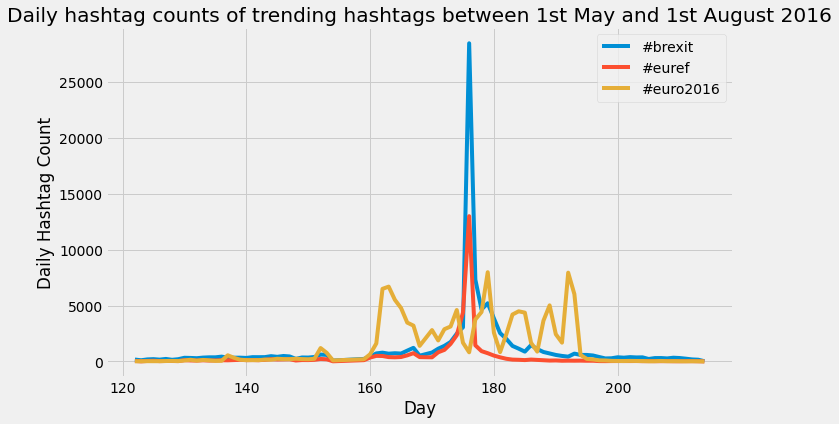

In [23]:
%%local
# Plot the timeseries of 3 trending hashtags in the local environment
plt.plot(brexit_series['days'], brexit_series['brexit_feat'])
plt.plot(euref_series['days'], euref_series['euref_feat'])
plt.plot(euro_series['days'], euro_series['euro_feat'])
plt.xlabel('Day')
plt.ylabel('Daily Hashtag Count')
plt.title('Daily hashtag counts of trending hashtags between 1st May and 1st August 2016')
plt.legend(['#brexit', '#euref', '#euro2016'])

***Observations:*** When inspecting the Brexit events, we can notice a significant count increase/spike  between the days 170-180. This period corresponds to the week of UK's referendum day, which was on the 23rd of June 2016. We can also notice how the timeseries of #brexit and #euref are highly correlated, which makes sense, since they correspond to the same event.
The #euro2016 timeseries has a different shape. It has a slight even distribution over the days = [160,...,190]. This can be explained by the event as is, since the European Footbal Championship '16 was not a single-day event, but a 4-week occasion.
It is also important to note that some days are missing, such as the 3rd June 2016 (as identified in 1d).

### II.h: TODO - Use KMeans to cluster hashtags based on the daily count timeseries (12 points / 50)

Use the DataFrame you created above to cluster the hashtag timeseries. Train the model and calculate the cluster membership for all hashtags. 

Show the cluster that includes "brexit" - does it make sense?

Again, be creative and see if you can get the clustering to give you meaningful hashtag groupings. Make sure you document your process and code and make your final notebook easy to understand even if the result is not optimal or complete. 

__Hint:__ Additional data cleaning or filtering might be necessary to get useful results from the model. 

***Chosen method/preprocessing:*** Before doing the KMeans on the feature vectors, it is necessary to do a preprocessing on the data. The first step is to only cluster hashtags which have a total count over the period below the threshhold of 150000 and above 100, which we have chosen by looking at the total counts of interesting hashtags like brexit or euro2016. With this step, we make sure that there are no spam hashtags which could overweigh the cluster centers, so that the interesting hashtags would all end up in one cluster.
We also find the max count and the min count for a hashtag and only keep hashtags that have significant changes over the course of time. This step aims to filter out the common hashtags people use everyday and are not related to current events.

In [30]:
# Rename feature vector for KMeans 
features = output.withColumnRenamed('feature_vector', 'features')
col = features.columns[1:-1]

minf = functions.lit(float("-inf"))
maxf = functions.lit(float("inf"))

rowmax = functions.greatest(*[functions.coalesce(functions.col(x), minf) for x in col])
rowmin = functions.least(*[functions.coalesce(functions.col(x), maxf) for x in col])

# Sum count of hashtags over total period and filter for hashtag counts below & above threshhold and with no significant change
newdf = features.withColumn('total', sum(features[c] for c in col))
newdf = newdf.withColumn('min', rowmin)
newdf = newdf.withColumn('max', rowmax)
filtered = newdf.filter((newdf.total <= 150000) & (newdf.total >= 100))
filtered = filtered.filter((filtered.max - filtered.min) >= 50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Initiate KMeans with k=10 clusters and use the filtered df with feature vectors as input
kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(filtered)
predictions = model.transform(filtered)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
# Associate each hashtag with a cluster
pred = predictions.select('hashtag', 'prediction')
pred.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+----------+
|           hashtag|prediction|
+------------------+----------+
|             anime|         0|
|               art|         1|
|           jewelry|         1|
|           eleague|         0|
|labourinforbritain|         0|
+------------------+----------+
only showing top 5 rows

*Lets look at what cluster #brexit is a part of and see what other hashtags are part of this cluster*

In [33]:
brex = pred.filter(pred.hashtag == 'brexit')
brex.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+
|hashtag|prediction|
+-------+----------+
| brexit|         3|
+-------+----------+

In [34]:
cluster1 = pred.filter(pred.prediction == 3)
cluster1.show(cluster1.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+
|hashtag|prediction|
+-------+----------+
| brexit|         3|
+-------+----------+

***Observations:*** We see that with k=10, for the #brexit cluster (3), there are no hashtags that no other hashtags other than #brexit. Another approach is needed.

***Another Approach***
In stead of using solely the daily counts we also wanted to incorporate daily rate of change. The intuition behind this is that two related hastags would likely to have spikes around the same time even if their daily counts are different. For example, the hashtag 'brexit' is much more commonly used than 'euref' but they both have sudden spikes on the same day. 

In [286]:
day_counts = daily_hashtag.cache()
day_counts = day_counts.groupBy('day','hashtag')\
                         .agg(functions.count('hashtag').alias('counts'))\
                         .sort('hashtag','day').na.fill(0)

# Add new column to dataframe with value from previous day for each hashtag
# The first day for each hashtag gets the previous value set to null
counts_window = Window.partitionBy('hashtag').orderBy(functions.asc('day'))
day_counts = day_counts.withColumn('prev', 
                                     functions.lag(day_counts.counts)\
                                              .over(counts_window)).na.fill(0)

day_counts.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+------+----+
|day|             hashtag|counts|prev|
+---+--------------------+------+----+
|190|                 08n|     1|   0|
|193|        100daysoffit|     1|   0|
|140|             100daze|     1|   0|
|124|            100pac12|     1|   0|
|127|            100pac12|     1|   1|
|131|            100pac12|     1|   1|
|138|            100pac12|     2|   1|
|145|            100pac12|     1|   2|
|152|            100pac12|     2|   1|
|159|            100pac12|     1|   2|
|144|100thindianapolis500|     1|   0|
|150|100thindianapolis500|     1|   1|
|125|    10añosrubelangel|     1|   0|
|138|       10daystill727|     2|   0|
|188|10kforindependenc...|     1|   0|
|190| 10marathonsin10days|     1|   0|
|130|            10points|     1|   0|
|136|            10points|     6|   1|
|140|            10points|     1|   6|
|198|            10points|     2|   1|
+---+--------------------+------+----+
only showing top 20 rows

In [287]:
#Calculate the daily count difference between hashtags
day_counts = day_counts.withColumn('diff', day_counts.counts - day_counts.prev)
day_counts = day_counts.drop('prev')
day_counts = day_counts.drop('counts')

pivot_daily1 = day_counts.groupBy('hashtag').pivot('day').agg({'diff': 'max'}).na.fill(0)

# Create input string list (res) with days for the Vector Assembler
selected = pivot_daily.drop('day')
selected = selected.drop('hashtag')
selected = selected.columns
res = [''.join(ele) for ele in selected]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [288]:
assembler1 = VectorAssembler(inputCols=res, outputCol= 'features1')
#output1 contains change in counts of two consecutive days
output1 = assembler1.transform(pivot_daily1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [289]:
for i in days:
    output1 = output1.withColumnRenamed(str(i), 'diff' + str(i))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [290]:
output1 = output1.withColumnRenamed('hashtag', 'hashtag1')
df = output1.join(output, (output1.hashtag1 == output.hashtag))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [293]:
s = df.drop('features1')
s = s.drop('feature_vector')
s = s.drop('hashtag')


selected = s.columns
res = [''.join(ele) for ele in selected]

assembler2 = VectorAssembler(inputCols=res, outputCol= 'features')
output2 = assembler2.transform(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [294]:
# Initiate KMeans with k=10 clusters and use the filtered df with feature vectors as input
kmeans1 = KMeans().setK(10).setSeed(1)
model1 = kmeans1.fit(output2)
predictions1 = model1.transform(output2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [295]:
pred1 = predictions1.select('hashtag', 'prediction')
brex = pred1.filter(pred1.hashtag == 'brexit')
brex.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+
|hashtag|prediction|
+-------+----------+
| brexit|         7|
+-------+----------+

In [296]:
cluster1 = pred1.filter(pred1.prediction == 7)
cluster1.show(cluster1.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+
|            hashtag|prediction|
+-------------------+----------+
|                art|         7|
|            jewelry|         7|
|             travel|         7|
|           etsymntt|         7|
|aldub1stanniversary|         7|
|           bigolive|         7|
|            android|         7|
|              euref|         7|
|           rncincle|         7|
|             hiring|         7|
|               mufc|         7|
|        gameinsight|         7|
|               mgwv|         7|
|              trump|         7|
|         soundcloud|         7|
|               news|         7|
|                 rt|         7|
|             dallas|         7|
|           giveaway|         7|
|               love|         7|
|               porn|         7|
|              porno|         7|
|           euro2016|         7|
|            metgala|         7|
|     teamfollowback|         7|
|                 np|         7|
|                job|         7|
|         

***Observations:*** With this approach we run into the same problem as the previous part where there is no optimal K to get satisfying results. With K = 10, we have a seemingly random set of hashtags that contains random hashtags, but also an associated hashtag to the brexit event (#euref). 